# mAiLab_0004_Edge Detection

In [1]:
import numpy as np
import requests
import os
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt
import math


### Data Preparation

In [2]:
#Preparation: Recall HW0003-1: 下載MNIST四個檔案, 並顯示training set的第一張圖
%run '../input/MNIST_utils.py'

filename_list = ['train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz',
                't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz']
#Download
for filename in filename_list:
    download_file('http://yann.lecun.com/exdb/mnist/' + filename, filename)

image, label = read_mnist(images=filename_list[0], labels=filename_list[1])
print('first label:{}'.format(label[0]))
print('first image:')
print_image(image[0])

100%|██████████| 4542/4542 [00:00<00:00, 3987134.53B/s]


first label:5
first image:
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 03 12 12 12 7E 88 AF 1A A6 FF F7 7F 00 00 00 00 
00 00 00 00 00 00 00 00 1E 24 5E 9A AA FD FD FD FD FD E1 AC FD F2 C3 40 00 00 00 00 
00 00 00 00 00 00 00 31 EE FD FD FD FD FD FD FD FD FB 5D 52 52 38 27 00 00 00 00 00 
00 00 00 00 00 00 00 12 DB FD FD FD FD FD C6 B6 F7 F1 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 50 9C 6B FD FD CD 0B 00 2B 9A 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 0E 01 9A FD 5A 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 8B FD

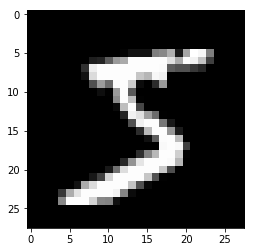

In [3]:
plt.imshow(image[0], cmap=plt.cm.gray)

### HW04 From Here...

image size after padding:  (30, 30)


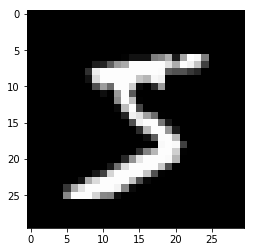

In [4]:
### mAiLab_0004：Edge Detection
# HW0004-1: 將作業3的前五個圖，增大至30x30後，
# 分別跑Gx與Gy，共輸出10個圖，以圖示呈現，並請反白處理。

#define Gx, Gy 
Gx = np.array([[-1, 0, 1], 
               [-2, 0, 2], 
               [-1, 0, 1]])
Gy = np.array([[ 1, 2, 1], 
               [ 0, 0, 0], 
               [-1,-2,-1]])

kernel_size = Gx.shape
    
#for kernel_size=3, padding=1, stride=1, this is the 'SAME' padding.
#verify conv image size
stride = 1
n_prev = (30, 30)
padding = 1
n = int((n_prev[0] + 2*padding - kernel_size[0])/stride) + 1

#generate padded image
print('image size after padding: ', (n, n))
plt.imshow(np.pad(image[0], [padding, padding], mode='edge'), cmap=plt.cm.gray)
    

In [5]:
# convolution computation  
def conv(image, conv_kernel, stride, padding):
    #initialize
    n_prev = image.shape[0]
    kernel_size = conv_kernel.shape[0]
    n = int((n_prev + 2*padding - kernel_size)/stride) + 1
    conv_image = np.zeros((n,n))
    padded_image = np.pad(image, [padding, padding], mode='edge')
    
    #origin at left-up, move the kernel
    half_len = initial_center =  math.ceil(kernel_size/2 - 1) #round up
    kernel_center = np.array((initial_center, initial_center))
    steps = n
    for i in range(steps):
        for j in range(steps):
            #define image window dimension
            left = kernel_center[1] - half_len
            right = kernel_center[1] + half_len
            up = kernel_center[0] - half_len
            down = kernel_center[0] + half_len
            
            #define image window
            image_window = padded_image[up:down+1, left:right+1]
            
            #debug
            #print(i,j,image_window.shape)
            
            conv_image[i,j] = np.sum(conv_kernel * image_window)
            kernel_center[1] += stride
        kernel_center[1] = initial_center
        kernel_center[0] += stride
    #conv_image = (conv_image)
    
    
    return conv_image.astype('int32')

Gx convolution:


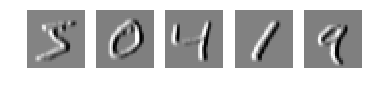

In [6]:
L = 5
print('Gx convolution:')
for i in range(L):
    plt.subplot(1, L, i + 1)
    plt.imshow(conv(image=image[i], conv_kernel=Gx, stride=1, padding=2), cmap=plt.cm.gray)
    plt.axis('off')



Gy convolution:


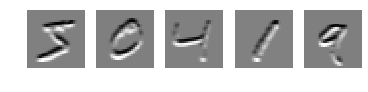

In [7]:
print('Gy convolution:')
for i in range(L):
    plt.subplot(1, L, i + 1)
    plt.imshow(conv(image=image[i], conv_kernel=Gy, stride=1, padding=2), cmap=plt.cm.gray)
    plt.axis('off')

In [8]:
# HW0004-1: 將作業3的第一個圖，分別增大至 32x32、34x34、36x36，然後跑5x5、7x7、9x9的filter
# ，輸出其值為 28x28 的矩陣
def kernel(kernel_size):
    kernel = np.zeros((kernel_size, kernel_size))
    #center = math.ceil(kernel_size/2)
    
    space_by_row = np.concatenate((np.ones(kernel_size//2), np.zeros(1), -1*np.ones(kernel_size//2)))
    up_row = bottom_row = np.linspace(kernel_size//2, -1*(kernel_size//2), kernel_size)
    
    for i in range(kernel_size//2):
        kernel[i] = up_row + i*space_by_row
        kernel[-1*(i+1)] = bottom_row + i*space_by_row
    kernel[kernel_size//2] = kernel[kernel_size//2 - 1] + space_by_row

    return kernel.astype('int')

kernel(9)

array([[ 4,  3,  2,  1,  0, -1, -2, -3, -4],
       [ 5,  4,  3,  2,  0, -2, -3, -4, -5],
       [ 6,  5,  4,  3,  0, -3, -4, -5, -6],
       [ 7,  6,  5,  4,  0, -4, -5, -6, -7],
       [ 8,  7,  6,  5,  0, -5, -6, -7, -8],
       [ 7,  6,  5,  4,  0, -4, -5, -6, -7],
       [ 6,  5,  4,  3,  0, -3, -4, -5, -6],
       [ 5,  4,  3,  2,  0, -2, -3, -4, -5],
       [ 4,  3,  2,  1,  0, -1, -2, -3, -4]])

In [9]:
img32x32 = conv(image[0], kernel(5), 1, 2)
img34x34 = conv(image[0], kernel(7), 1, 3)
img36x36 = conv(image[0], kernel(9), 1, 4)

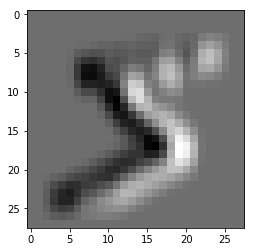

In [10]:
plt.imshow(img32x32, cmap=plt.cm.gray)

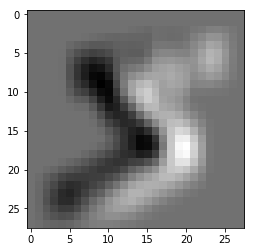

In [11]:
plt.imshow(img34x34, cmap=plt.cm.gray)

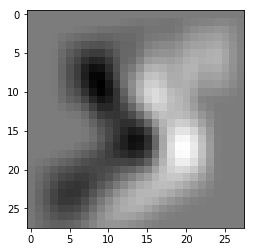

In [12]:
plt.imshow(img36x36, cmap=plt.cm.gray)

In [13]:
#print out image by a two digits hexadecimal matrix
def print_image(file):
    for i in file:
        for j in i:
            # {:02X} output the pixel numbers by two digits hexadecimal
            # example: 255 -> FF ; 14 -> 1E
            print("{:02X}".format(j.astype("uint8")), end=' ') 
        print()
    print()

In [14]:
print('32x32')
print()
print_image(img32x32)

32x32

00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 FA D9 CA CD 0A A8 50 BF 1E 1B 8B E5 CC F5 6D FE 00 00 
00 00 00 00 00 00 C4 9A 20 8C 69 C6 05 93 E9 C6 75 44 B5 A7 54 41 9E 92 A9 FD 00 00 
00 00 00 00 00 9E 99 70 D8 0B 46 8C DF BC 1B E8 C0 6E 4B B9 85 00 4F D4 70 BC 00 00 
00 00 00 00 00 49 94 6E A8 5E F4 7C 6F EC 96 B3 E2 C2 89 C6 DA D9 62 F2 24 7D 00 00 
00 00 00 00 00 06 06 65 07 3B 0D C2 BC 2D 22 B8 82 B1 1E 38 7F 66 17 A6 D2 BE 00 00 
00 00 00 00 00 25 06 B2 53 96 6E B7 FD B4 AB B0 70 12 08 EB CC 5E 12 9D 3B 80 00 00 
00 00 00 00 00 68 FE E1 CE 29 11 31 01 E6 B2 BE 80 87 40 CC 86 CF DC 97 4E 00 00 00 
00 00 00 00 00 DC 48 7F 74 B9 C7 39 C8 24 51 26 D0 B9 94 B0 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 60 4E 6F CE 0B C9 69 E4 3D 2A B7 D7 C9 3

In [15]:
print('34x34')
print()
print_image(img34x34)

34x34

00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 F7 C4 A3 94 53 72 A4 38 03 57 B0 A6 F2 1A E7 6A E3 7D 00 
00 00 00 00 00 A6 58 80 52 82 2A E1 32 BE A0 71 48 F4 22 71 AF A0 0A 21 7B 22 BC 00 
00 00 00 00 6D 5C 12 01 79 5D 94 89 21 CA ED 90 DD 8B 25 C6 97 06 77 FC DB 10 7B 00 
00 00 00 00 06 6A F5 AD BB 0F A0 8E 53 AD AD 4B C4 D6 F4 73 26 60 EE FB A4 B0 3A 00 
00 00 00 00 C3 50 39 87 8B A0 AC 92 F0 27 EF 59 04 C5 9E C4 E9 C8 E5 C2 83 64 FB 00 
00 00 00 00 80 12 5F F4 1A 04 69 B1 17 02 27 53 D3 C4 65 D3 4E 22 26 25 78 12 3C 00 
00 00 00 00 9F 12 D9 41 C9 9F CE BB EA 52 83 2A 92 DD FA 9A 1D C8 AF 26 AF 72 7D 00 
00 00 00 00 E2 EC 27 38 37 89 6F 09 7B AB 3F E1 F3 0E 55 FA 40 75 5E DC F1 65 C0 00 
00 00 00 00 25 A2 B3 BD 55 A0 AF 6E 4C 4D 6A CF 46 48 20 47 40 E6 D2 8D F6 75 00 00 
00 00 00 00 CA 0B 9B D7 0E 81 E9 27 4C 60 20 4E 7E 8B E4 F

In [16]:
print('36x36')
print()
print_image(img36x36)

36x36

00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 F4 AF 7C 5B 9C 33 B6 3C AC 4F C3 FC 9E 12 D6 4F 02 DF 59 FC 
00 00 00 00 88 16 E0 18 9B 34 DC 93 40 B2 29 A7 CD 7F 91 44 19 3C F9 53 AD E5 9B 7B 
00 00 00 3C 1F B4 48 0B 21 0C 43 FC 96 65 C4 46 18 48 41 DD 70 13 6A 3C F8 A4 B0 3A 
00 00 00 C3 40 AD DC 2C C5 BE 2B 96 EC 19 E6 74 A8 6A 53 AF 53 B1 CE 53 B6 6D 50 F9 
00 00 00 80 D6 05 1C 7E FA 0C 0F CD 29 0A 39 D6 58 D3 CC 35 E9 E4 32 6A 74 36 F0 B8 
00 00 00 3D 5C 99 F7 B2 BF 4E 15 89 33 32 3D 77 EA 9B 11 73 16 47 B8 15 FC 15 A4 79 
00 00 00 FA 1E DB 31 0C A7 2F FD 14 5D 01 D8 29 CF 63 32 E5 1F A2 C6 04 A0 0A 52 BA 
00 00 00 19 1E 55 9D A5 09 35 7E 8D 29 CF B6 8E CA 3D 87 15 98 53 62 ED E2 41 B2 FB 
00 00 00 5C F8 A3 D7 03 F3 9A 92 85 34 2C D0 6D 01 C7 7F CF F4 26 FE D6 24 78 12 3C 
00 00 00 9F 72 C9 BF 09 51 D4 C4 12 96 8B 84 74 53 FF 61 E8 C7 58 17 26 7F 45 8F 00 
00 00 00 E2 46 B3 45 0F 7F 79 73 D1 49 CD DF D9 FF BC 39 4